In [4]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import mdl.md2l as mdl

# 门控循环单元(GRU)
传统的 `RNN` 可能存在的问题:
1. 早期观测对于预测未来值得有比较重要的作用(此时如果使用截断法可能降低第一个词元对于结果的影响)
2. 一些词元没有相关的观测值, 比如利用网页进行情感分析的时候, 可能有一些辅助 `HTML` 代码与网页传达的心绪无关, 需要一些机制可以跳过隐状态
3. 序列各个部分之间可能存在逻辑中断(比如书的章节可能存在过渡)

可以解决这些问题的方法比如长短期记忆(`LSTM`), 并且门控循环单元(`GRU`)是一个稍微简单的变种, 可以提供同等效果

## 门控隐状态
门控循环单元与普通的`RNN`循环单元不同之处在与: **前者支持隐状态的门控, 表示模型有专门的机制来确定合适更新隐状态以及何时重置隐状态, 同时这一种机制是可以学习** (本质上, 前面序列对于后面序列的影响体现在隐状态中, `GRU` 中的门控隐状态可以控制隐状态的更新时机等)

### 重置门和更新门
重置门和更新门, 可以设置为 $(0, 1)$区间中的向量, 这样可以进行而这的凸组合, 重置门允许控制可能想要记住的过去状态的数量, 更新门允许控制新状态中有多少个旧状态的副本

此时一个门控循环单元的结构如下:
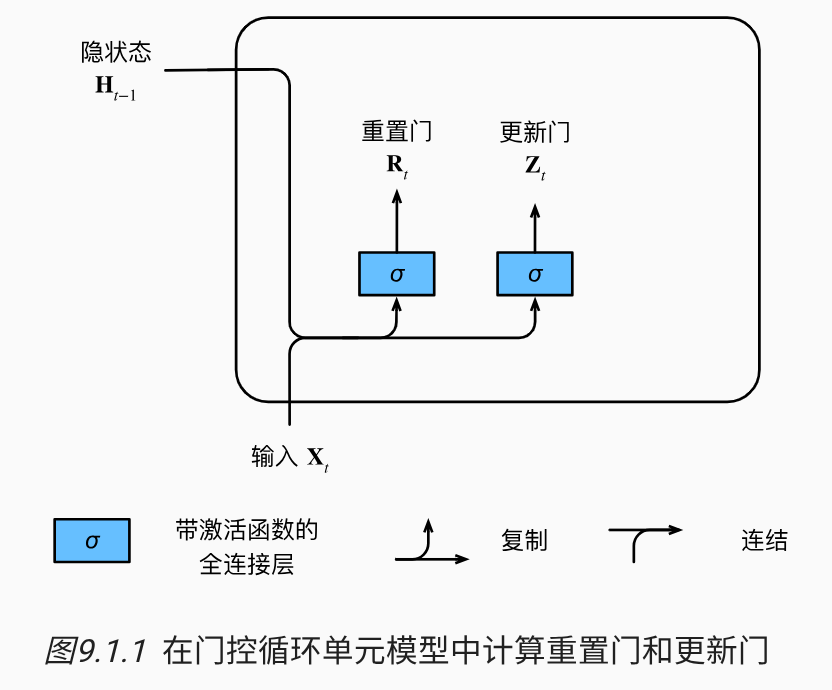
对于给定的时间步 $t$, 假设输入是一个小批量 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$(样本个数为 $n$, 输出个数为 $d$), 上一个时间步的隐状态为 $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$(隐藏单元个数 $h$), 重置门 $\mathbf{R}_t \in \mathbb{R}^{n \times h}$以及更新门 $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$计算方式如下:
$$
\begin{align}
\mathbf{R}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r), \\
\mathbf{Z}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{align}
$$
其中 $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h} $ 以及 $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ 为权重参数, $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ 为偏置参数

### 候选隐状态
接下来考虑 $\mathbb{R}_t$ 与常规隐状态更新机制集成结合, 可以得到时间步$t$的候选隐状态 $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$:
$$
\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + (\mathbf{R}_t \odot \mathbf{H}_{t-1}) \mathbf{W}_{hh} + \mathbf{b}_h),
$$
其中 $\mathbf{R}_t$ 相当于作为加权系数, 用于减少以往隐状态的影响, 当重置门 $\mathbf{R}_t$ 的项接近 $1$ 的时候, 可以恢复一个普通循环神经网络(候选值就是正常 `RNN` 中的 $\mathbf{H}_t$)同时如果 $\mathbf{R}_t$ 接近 $0$, 相当于候选状态就是 $\mathbf{X}_t$ 作为输入的多层感知机结果(没有以以往状态的影响)

应用重置门之后的计算流程:
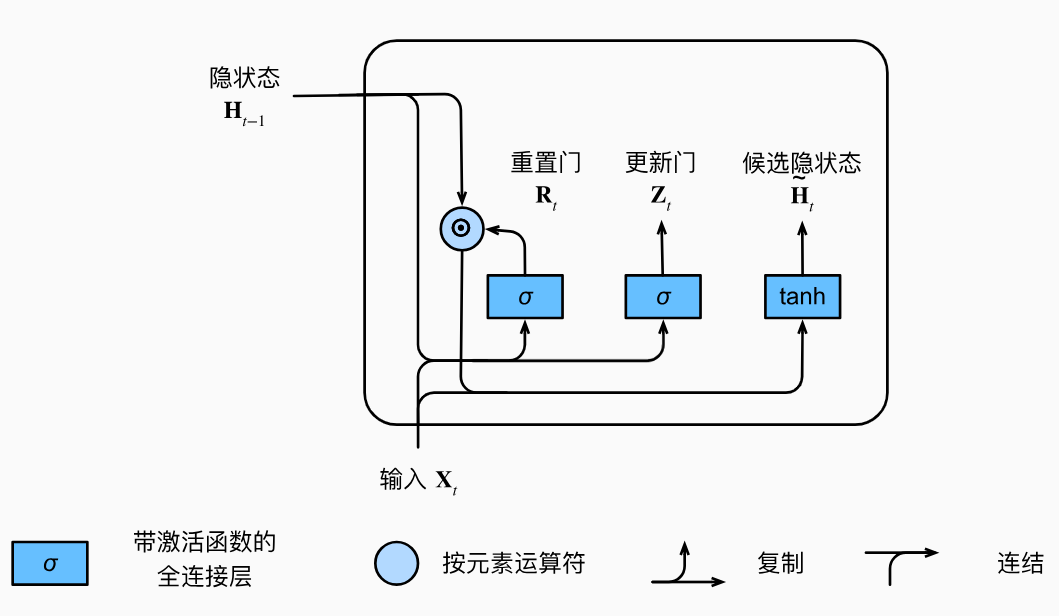

### 隐状态
需要结合 $\mathbf{Z}_t$ 的效果来确定隐状态的更新, 隐状态的更新取决于 $\tilde{\mathbf{H}}_t$ 以及 $\mathbf{H}_{t-1}$, 更新公式如下:
$$
\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1} + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t
$$

可以发现此时现在状态 $\mathbf{X}_t$ 包含在了 $\tilde{\mathbf{H}}_t$ 中了, **所以 $\mathbf{Z}_t$ 占比越大, 前面的序列对于当前隐状态(当前输出)的影响越大, 同时 $\mathbf{R}_t$ 占比越大, 当前值对于当前隐状态影响越大 ; 特别是 $\mathbf{Z}_t$ 元素全部接近与 $1$ 的时候, 此时输出仅仅取决于之前的序列, $\mathbf{Z}_t$ 接近 $0$ 的时候, 那么此时隐状态等于候选隐状态, 取决与 $\mathbf{R}_t$, 值越小, 那么重置效果越好**

此时完整的门控单元如下:
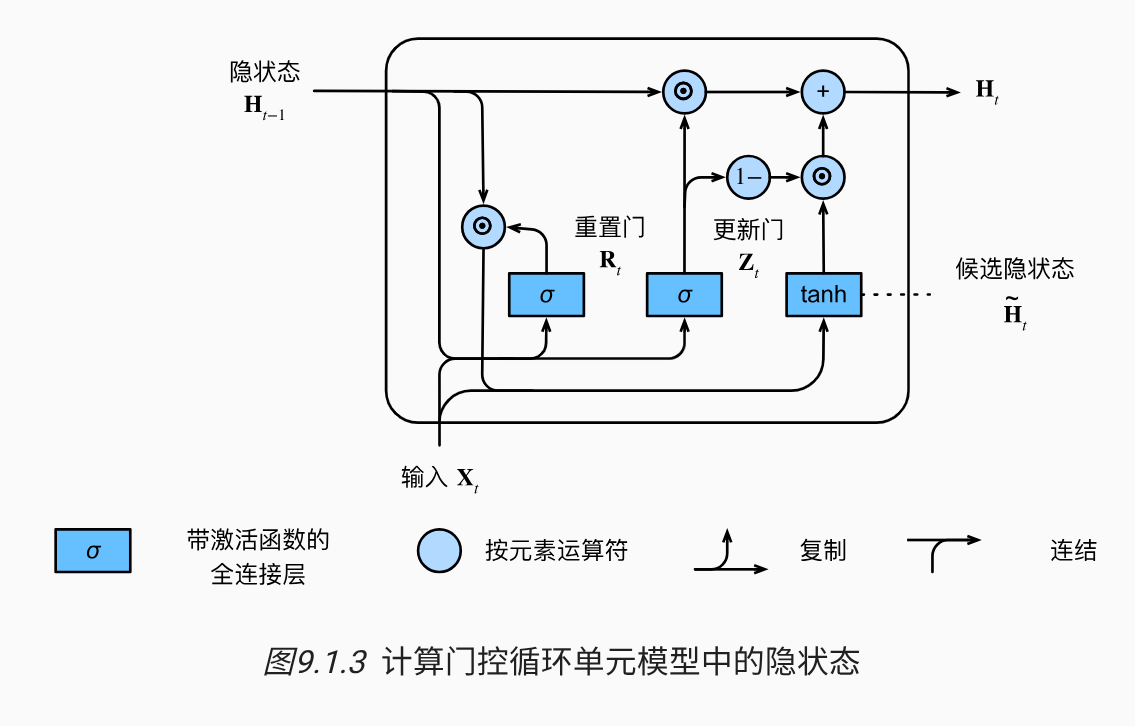

## GRU 实现(造轮子)

In [5]:
# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = mdl.load_data_time_machine(batch_size, num_steps)

### 初始化模型参数
需要初始化 $\mathbf{Z}_t$ 和 $\mathbf{R}_t$ 以及和输出相关的权重和偏置等参数

In [6]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型
主要是定义模型中各个参数的计算方式

In [7]:
# 初始化 GRU 状态(返回初始化的隐状态)
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [8]:
# 定义门控循环单元模型
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs: # 此时 X 为单一时间步下 n*len(vocab) 大小的矩阵
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z)*H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,) # H 表示最后一个隐状态

## 训练以及预测

困惑度 1.1, 33288.8 词元/秒 cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


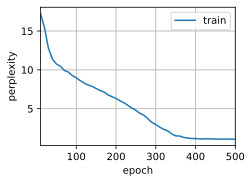

In [12]:
vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mdl.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
mdl.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 简结实现

困惑度 1.0, 67705.9 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


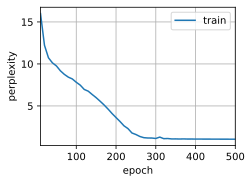

In [11]:
vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = mdl.RNNModel(gru_layer, len(vocab))
model = model.to(device)
mdl.train_ch8(model, train_iter, vocab, lr, num_epochs, device)